# Python Notebook for CASA0010
## The Spatial Analysis of Violece and Property Crime in London at MSOA Level

### Student ID: 19053110

## Part 1 Data pre-processing 

In [1]:
#Firstly import packages that will be used in this study
import pandas as pd
import numpy as np
from matplotlib import pyplot
from sklearn import preprocessing
from pandas import DataFrame

import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as sps

import sklearn.metrics as sklm 
import seaborn as sns
from statsmodels.graphics.regressionplots import plot_partregress_grid
from statsmodels.formula.api import ols

## 1.Data cleaning

In [2]:
df1 = pd.read_csv('Violent_Sum.csv')
df2 = pd.read_csv('IMD_2015_score.csv')
df3 = pd.read_csv('LSOA_MSOA.csv')
df4 = pd.read_csv('independent.csv')

In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29355 entries, 0 to 29354
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   LSOACode        29355 non-null  object
 1   Violence_Total  29355 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 458.8+ KB


In [4]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32844 entries, 0 to 32843
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   LSOAcode                 32844 non-null  object 
 1   LSOAname                 32844 non-null  object 
 2   IMD                      32844 non-null  float64
 3   Income                   32844 non-null  float64
 4   Employment               32844 non-null  float64
 5   EducationSkillsTraining  32844 non-null  float64
 6   LivingEnvironment        32844 non-null  float64
dtypes: float64(5), object(2)
memory usage: 1.8+ MB


In [5]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   MSOAcode                           983 non-null    object 
 1   MSOAName                           983 non-null    object 
 2   Population                         983 non-null    object 
 3   PopDensity                         983 non-null    int64  
 4   Age16_29%                          983 non-null    float64
 5   BAME%                              983 non-null    float64
 6   Householdspaces_no_usualresidents  983 non-null    float64
 7   Household_Income                   983 non-null    float64
 8   House_Price                        983 non-null    float64
dtypes: float64(5), int64(1), object(3)
memory usage: 69.2+ KB


### 1.1 Data Join

In [6]:
# Combine LSOA related data collection into MSOA level
df2_1 = pd.merge(left=df2, right=df3, how='inner', left_on='LSOAcode', right_on='LSOA11CD')
df2_1.shape

(171372, 9)

In [7]:
df2_1.head()

,LSOAcode,LSOAname,IMD,Income,Employment,EducationSkillsTraining,LivingEnvironment,LSOA11CD,MSOA11CD
0,E01031349,Adur 001A,12.389,0.096,0.083,20.055,15.180,E01031349,E02006534
1,E01031349,Adur 001A,12.389,0.096,0.083,20.055,15.180,E01031349,E02006534
2,E01031349,Adur 001A,12.389,0.096,0.083,20.055,15.180,E01031349,E02006534
3,E01031349,Adur 001A,12.389,0.096,0.083,20.055,15.180,E01031349,E02006534
4,E01031350,Adur 001B,28.619,0.187,0.162,34.653,17.837,E01031350,E02006534


In [8]:
df2_1 = df2_1.drop_duplicates()
df2_1.shape

(32844, 9)

In [9]:
#Then convert the LSOA dataset to MSOA level
df2_2 = pd.merge(left=df4, right=df2_1, how='left', left_on='MSOAcode', right_on='MSOA11CD')
df2_3 = df2_2.groupby(['MSOAcode'])['Employment'].agg(['mean']).reset_index().rename(columns={'mean':'Employment_Deprivation',})
df2_4 = df2_2.groupby(['MSOAcode'])['EducationSkillsTraining'].agg(['mean']).reset_index().rename(columns={'mean':'EducationSkills_Deprivation',})
df2_5 = df2_2.groupby(['MSOAcode'])['LivingEnvironment'].agg(['mean']).reset_index().rename(columns={'mean':'LivingEnvironment_Deprivation',})

df2_6 = pd.merge(left=df2_3, right=df2_4, how='left', on='MSOAcode')
df2_6 = pd.merge(left=df2_6, right=df2_5, how='left', on='MSOAcode')

df2_6.head()

,MSOAcode,Employment_Deprivation,EducationSkills_Deprivation,LivingEnvironment_Deprivation
0,E02000001,0.05100,4.410667,49.352500
1,E02000002,0.17075,33.099000,17.855250
2,E02000003,0.11550,17.473333,28.351333
3,E02000004,0.13800,23.301000,16.275500
4,E02000005,0.15240,27.740600,29.729600


In [10]:
df2_6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983 entries, 0 to 982
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   MSOAcode                       983 non-null    object 
 1   Employment_Deprivation         983 non-null    float64
 2   EducationSkills_Deprivation    983 non-null    float64
 3   LivingEnvironment_Deprivation  983 non-null    float64
dtypes: float64(3), object(1)
memory usage: 38.4+ KB


In [11]:
#Summarise the IMD data to Data_indepent
df4_final = pd.merge(left=df4, right=df2_6, how='left', on='MSOAcode')
df4_final.head()

,MSOAcode,MSOAName,Population,PopDensity,Age16_29%,BAME%,Householdspaces_no_usualresidents,Household_Income,House_Price,Employment_Deprivation,EducationSkills_Deprivation,LivingEnvironment_Deprivation
0,E02000001,City of London 001,"8,760",30,20.0228,21.4,1.315970,4.901458,5.968178,0.05100,4.410667,49.352500
1,E02000002,Barking and Dagenham 001,"7,301",34,17.7236,35.0,0.462398,4.586587,5.376292,0.17075,33.099000,17.855250
2,E02000003,Barking and Dagenham 002,"10,810",50,18.6031,45.4,0.447158,4.666518,5.398329,0.11550,17.473333,28.351333
3,E02000004,Barking and Dagenham 003,"6,491",26,21.9535,19.0,0.278754,4.656098,5.415759,0.13800,23.301000,16.275500
4,E02000005,Barking and Dagenham 004,"9,060",76,18.4989,33.7,0.431364,4.612784,5.398138,0.15240,27.740600,29.729600


In [12]:
df4_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983 entries, 0 to 982
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   MSOAcode                           983 non-null    object 
 1   MSOAName                           983 non-null    object 
 2   Population                         983 non-null    object 
 3   PopDensity                         983 non-null    int64  
 4   Age16_29%                          983 non-null    float64
 5   BAME%                              983 non-null    float64
 6   Householdspaces_no_usualresidents  983 non-null    float64
 7   Household_Income                   983 non-null    float64
 8   House_Price                        983 non-null    float64
 9   Employment_Deprivation             983 non-null    float64
 10  EducationSkills_Deprivation        983 non-null    float64
 11  LivingEnvironment_Deprivation      983 non-null    float64

In [14]:
df4_final.to_csv('x_final_violent.csv',encoding="utf-8")

### Convert the crime data from LSOA to MSOA level  

In [15]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29355 entries, 0 to 29354
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   LSOACode        29355 non-null  object
 1   Violence_Total  29355 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 458.8+ KB


In [16]:
df1.head()

,LSOACode,Violence_Total
0,E01000006,5
1,E01000006,8
2,E01000006,14
3,E01000006,0
4,E01000006,3


In [17]:
df1_1 = df1.groupby('LSOACode').sum().reset_index()

In [18]:
df1_1.head()

,LSOACode,Violence_Total
0,E01000006,32
1,E01000007,182
2,E01000008,59
3,E01000009,83
4,E01000010,330


In [19]:
df1_2 = pd.merge(left=df1_1, right=df3, how='inner', left_on='LSOACode', right_on='LSOA11CD')

In [20]:
df1_2 = df1_2.drop_duplicates()
df1_2.shape

(4831, 4)

In [21]:
df1_2.head()

,LSOACode,Violence_Total,LSOA11CD,MSOA11CD
0,E01000006,32,E01000006,E02000017
5,E01000007,182,E01000007,E02000016
9,E01000008,59,E01000008,E02000016
13,E01000009,83,E01000009,E02000017
18,E01000010,330,E01000010,E02000016


In [22]:
# Summarise the number of crime from LSOA level to MSOA level
df1_2 = df1_2.groupby('MSOA11CD').sum().reset_index()
df1_1.shape

(4831, 2)

In [23]:
df1_2.head()

,MSOA11CD,Violence_Total
0,E02000001,16
1,E02000002,224
2,E02000003,294
3,E02000004,121
4,E02000005,245


In [24]:
df1_2 = df1_2.drop_duplicates()

In [25]:
df1_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983 entries, 0 to 982
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   MSOA11CD   983 non-null    object
 1   Theft_Sum  983 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 23.0+ KB


In [25]:
df1_2.rename(columns = {'MSOA11CD':'MSOAcode'},inplace=True)

In [26]:
df1_2.to_csv('Violent_MSOA.csv',encoding="utf-8")

In [27]:
#Merge the crime data to the independent_final data, then get the whole datasets
df_all = pd.merge(left=df4_final, right=df1_2, how='left', on='MSOAcode')

In [28]:
df_all.head()

,MSOAcode,MSOAName,Population,PopDensity,Age16_29%,BAME%,Householdspaces_no_usualresidents,Household_Income,House_Price,Employment_Deprivation,EducationSkills_Deprivation,LivingEnvironment_Deprivation,Violence_Total
0,E02000001,City of London 001,"8,760",30,20.0228,21.4,1.315970,4.901458,5.968178,0.05100,4.410667,49.352500,16
1,E02000002,Barking and Dagenham 001,"7,301",34,17.7236,35.0,0.462398,4.586587,5.376292,0.17075,33.099000,17.855250,224
2,E02000003,Barking and Dagenham 002,"10,810",50,18.6031,45.4,0.447158,4.666518,5.398329,0.11550,17.473333,28.351333,294
3,E02000004,Barking and Dagenham 003,"6,491",26,21.9535,19.0,0.278754,4.656098,5.415759,0.13800,23.301000,16.275500,121
4,E02000005,Barking and Dagenham 004,"9,060",76,18.4989,33.7,0.431364,4.612784,5.398138,0.15240,27.740600,29.729600,245


In [29]:
#Here, in order to smooth and reduce the heteroskedasticity of the data, we use log(crime rate) to do research, 
#So we first save this file and then calculate log(crime rate) by using excel
#How to calculate crime rate? ------(the number of crime/population)*1000
#Then,save the file as "Data_Total.csv" for later use
df_all.to_csv('data_to_handle_violent.csv',encoding="utf-8")

In [11]:
df_all = pd.read_csv('Data_Total_violent.csv')
df_all.head()

,MSOAcode,MSOAName,log_Violent,Population,PopDensity,Age16_29%,BAME%,Householdspaces_no_usualresidents,Household_Income,House_Price,Employment_Deprivation,EducationSkills_Deprivation,LivingEnvironment_Deprivation,Violence_Total
0,E02000001,City of London 001,0.261616,"8,760",30,20.0228,21.4,1.315970,4.901458,5.968178,0.05100,4.410667,49.352500,16
1,E02000002,Barking and Dagenham 001,1.486866,"7,301",34,17.7236,35.0,0.462398,4.586587,5.376292,0.17075,33.099000,17.855250,224
2,E02000003,Barking and Dagenham 002,1.434522,"10,810",50,18.6031,45.4,0.447158,4.666518,5.398329,0.11550,17.473333,28.351333,294
3,E02000004,Barking and Dagenham 003,1.270474,"6,491",26,21.9535,19.0,0.278754,4.656098,5.415759,0.13800,23.301000,16.275500,121
4,E02000005,Barking and Dagenham 004,1.432038,"9,060",76,18.4989,33.7,0.431364,4.612784,5.398138,0.15240,27.740600,29.729600,245


In [12]:
# Drop the Area and Poplution colums
df_all = df_all.drop(columns=['Population','MSOAName','Violence_Total'], axis=1)

In [13]:
df_all.head()

,MSOAcode,log_Violent,PopDensity,Age16_29%,BAME%,Householdspaces_no_usualresidents,Household_Income,House_Price,Employment_Deprivation,EducationSkills_Deprivation,LivingEnvironment_Deprivation
0,E02000001,0.261616,30,20.0228,21.4,1.315970,4.901458,5.968178,0.05100,4.410667,49.352500
1,E02000002,1.486866,34,17.7236,35.0,0.462398,4.586587,5.376292,0.17075,33.099000,17.855250
2,E02000003,1.434522,50,18.6031,45.4,0.447158,4.666518,5.398329,0.11550,17.473333,28.351333
3,E02000004,1.270474,26,21.9535,19.0,0.278754,4.656098,5.415759,0.13800,23.301000,16.275500
4,E02000005,1.432038,76,18.4989,33.7,0.431364,4.612784,5.398138,0.15240,27.740600,29.729600


In [14]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   MSOAcode                           983 non-null    object 
 1   log_Violent                        983 non-null    float64
 2   PopDensity                         983 non-null    int64  
 3   Age16_29%                          983 non-null    float64
 4   BAME%                              983 non-null    float64
 5   Householdspaces_no_usualresidents  983 non-null    float64
 6   Household_Income                   983 non-null    float64
 7   House_Price                        983 non-null    float64
 8   Employment_Deprivation             983 non-null    float64
 9   EducationSkills_Deprivation        983 non-null    float64
 10  LivingEnvironment_Deprivation      983 non-null    float64
dtypes: float64(9), int64(1), object(1)
memory usage: 84.6+ KB


### Below datafile will be used for OLS and GWR models in RStudio

In [33]:
df_all.to_csv('xy_final_violent.csv',encoding="utf-8")

## 1.2 Data Summary Statistics

Below are the description and boxplot of the final data, we can find that there is a gap in some variables, such as popdensity and there are some outliers in some variables, but the outliers do not mean abnormal or wrong and due to the OLS model we are going to conduct is not as sensitive to outliers as logistic regression, so ouliers are remained.

In [15]:
df_all.describe()

,log_Violent,PopDensity,Age16_29%,BAME%,Householdspaces_no_usualresidents,Household_Income,House_Price,Employment_Deprivation,EducationSkills_Deprivation,LivingEnvironment_Deprivation
count,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000
mean,1.361694,88.545270,20.280276,39.419532,0.440051,4.701919,5.658225,0.111091,14.129312,30.526664
std,0.223518,51.462736,5.261931,19.309944,0.244703,0.086687,0.212780,0.047190,9.175755,13.029274
min,0.261616,3.000000,10.353900,3.800000,-0.301030,4.505150,5.261620,0.008000,0.510250,5.785000
25%,1.225017,49.500000,16.917900,23.700000,0.278754,4.640481,5.500952,0.073675,6.870383,20.467375
50%,1.372378,78.000000,19.268100,37.300000,0.397940,4.693727,5.623290,0.107000,12.570600,29.867000
75%,1.503910,120.000000,22.506850,53.600000,0.568202,4.757396,5.780549,0.143775,19.688000,39.414458
max,2.562301,274.000000,50.232800,93.900000,1.456366,5.024075,6.660628,0.275000,47.364000,73.181500


In [35]:
Description = df_all.describe()
Description.to_csv('Description_violent.csv',encoding="utf-8")

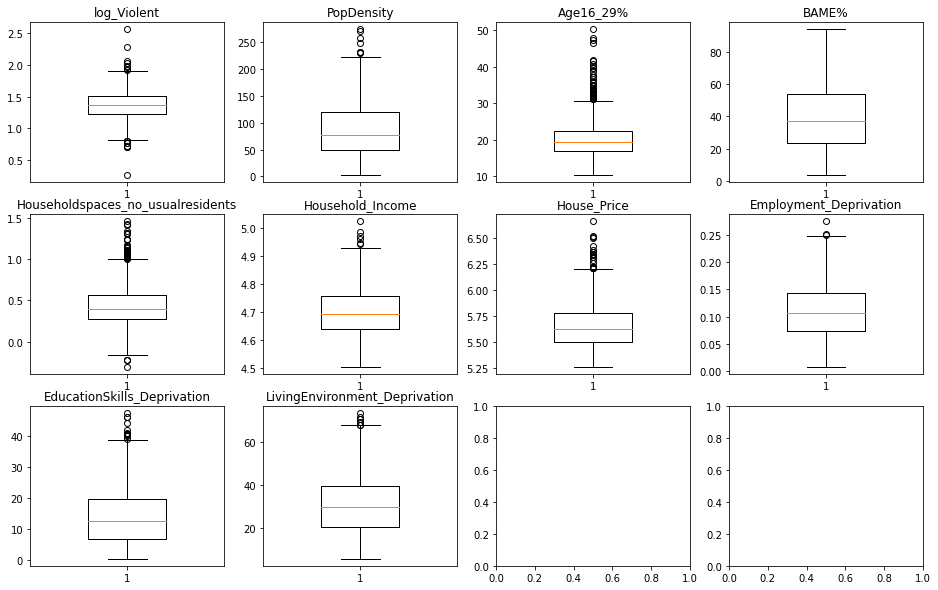

In [37]:
# Check outliers by using boxplot 
figure,axes =plt.subplots(3,4,figsize=(16,10))
axes[0][0].boxplot(df_all['log_Violent'],widths = 0.4)
axes[0][0].set_title('log_Violent')
axes[0][1].boxplot(df_all['PopDensity'],widths = 0.4)
axes[0][1].set_title('PopDensity')
axes[0][2].boxplot(df_all['Age16_29%'],widths = 0.4)
axes[0][2].set_title('Age16_29%')
axes[0][3].boxplot(df_all['BAME%'],widths = 0.4)
axes[0][3].set_title('BAME%')
axes[1][0].boxplot(df_all['Householdspaces_no_usualresidents'],widths = 0.4)
axes[1][0].set_title('Householdspaces_no_usualresidents')
axes[1][1].boxplot(df_all['Household_Income'],widths = 0.4)
axes[1][1].set_title('Household_Income')
axes[1][2].boxplot(df_all['House_Price'],widths = 0.4)
axes[1][2].set_title('House_Price')
axes[1][3].boxplot(df_all['Employment_Deprivation'],widths = 0.4)
axes[1][3].set_title('Employment_Deprivation')
axes[2][0].boxplot(df_all['EducationSkills_Deprivation'],widths = 0.4)
axes[2][0].set_title('EducationSkills_Deprivation')
axes[2][1].boxplot(df_all['LivingEnvironment_Deprivation'],widths = 0.4)
axes[2][1].set_title('LivingEnvironment_Deprivation')


plt.savefig("Boxplot_violent.png",dpi=300)

# 2.OLS regression test

## 2.1 Check for roughly normal distribution or not

In [38]:
# Plot histograms of the variables to see distributions

In [183]:
df_all.dropna(inplace=True)  

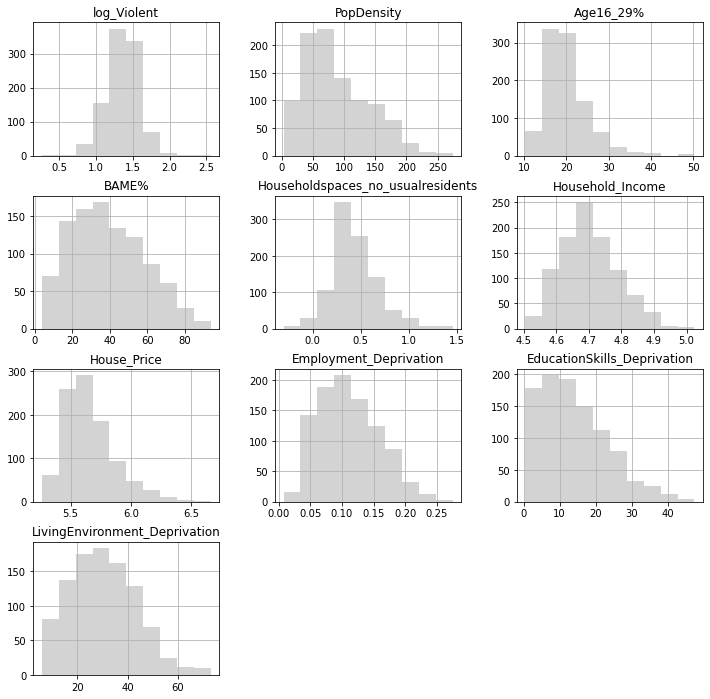

In [39]:
# First, plot histograms of the variables to see distributions
Histograms = df_all[["log_Violent", "PopDensity", "Age16_29%" , "BAME%" , "Householdspaces_no_usualresidents",
                     "Household_Income", "House_Price", "Employment_Deprivation",
                     "EducationSkills_Deprivation", "LivingEnvironment_Deprivation"]]
Histograms.hist(figsize=(12,12),color = 'lightgrey')
plt.savefig("Histograms_violent.png",dpi=300)
pyplot.show()

## 2.2 Correlation analysis

In [40]:
#Check for correlation of individual social status and health condition
Correlation = df_all[["log_Violent", "PopDensity", "Age16_29%" , "BAME%" , "Householdspaces_no_usualresidents", 
                     "Household_Income", "House_Price", "Employment_Deprivation",
                     "EducationSkills_Deprivation", "LivingEnvironment_Deprivation"]]
Correlation_analysis = Correlation.corr()

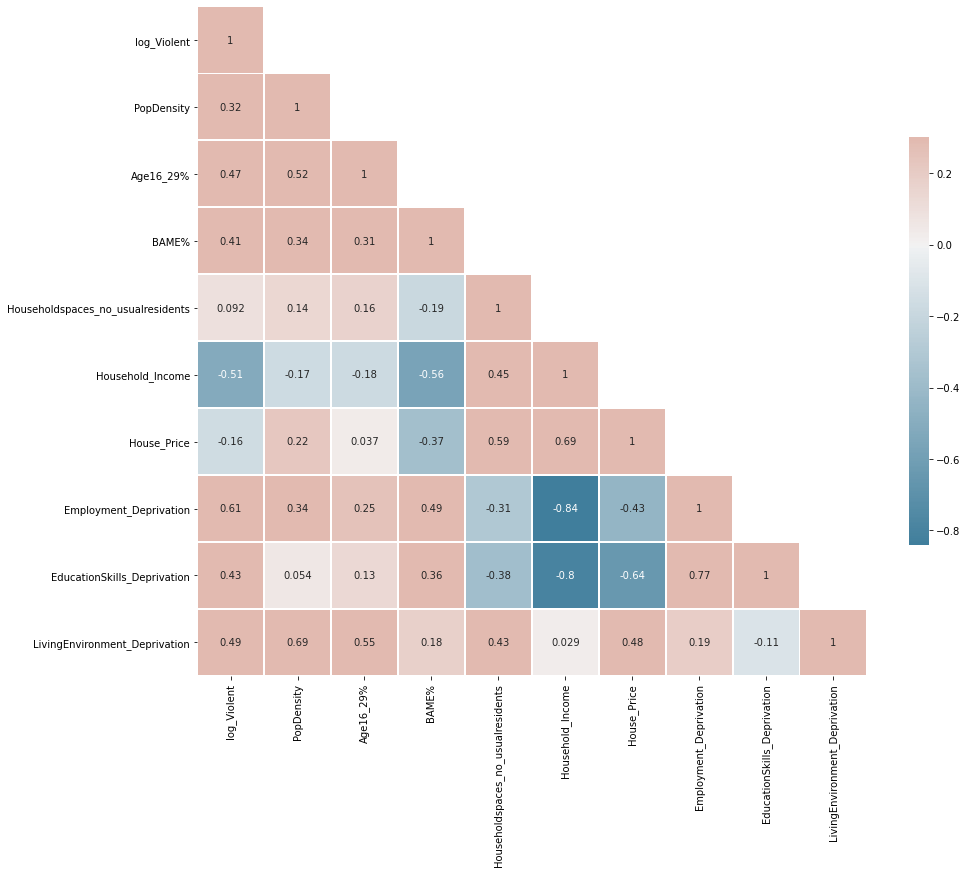

In [41]:
#Plot the heatmap of correlation
Correlation_analysis
mask = np.array(Correlation_analysis)
mask[np.tril_indices_from(mask)]=False
fig = plt.figure(figsize=(15,15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(Correlation_analysis, mask=mask, annot=True, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.savefig("Correlation_violent.png",dpi=300)

## 2.3 VIF test

In [42]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=6):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [43]:
df_all_drop = df_all.drop(columns=['MSOAcode'], axis=1)

In [44]:
df_all_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   log_Violent                        983 non-null    float64
 1   PopDensity                         983 non-null    int64  
 2   Age16_29%                          983 non-null    float64
 3   BAME%                              983 non-null    float64
 4   Householdspaces_no_usualresidents  983 non-null    float64
 5   Household_Income                   983 non-null    float64
 6   House_Price                        983 non-null    float64
 7   Employment_Deprivation             983 non-null    float64
 8   EducationSkills_Deprivation        983 non-null    float64
 9   LivingEnvironment_Deprivation      983 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 76.9 KB


In [45]:
# Using VIF on the df_final dataset
predictors_df_final_drop = df_all_drop.drop({'log_Violent'}, axis=1)
response_df_final_drop = df_all_drop['log_Violent']


In [46]:
df_predictors_select_VIF = drop_column_using_vif_(predictors_df_final_drop, thresh=6)
print("The columns remaining after VIF selection are:")
print(df_predictors_select_VIF.columns)

Dropping: Household_Income
The columns remaining after VIF selection are:
Index(['PopDensity', 'Age16_29%', 'BAME%', 'Householdspaces_no_usualresidents',
       'House_Price', 'Employment_Deprivation', 'EducationSkills_Deprivation',
       'LivingEnvironment_Deprivation'],
      dtype='object')


In [47]:
predictors_df_final_drop = df_all_drop.drop({'log_Violent','Household_Income'}, axis=1)

In [48]:
df_predictors_select_VIF = drop_column_using_vif_(predictors_df_final_drop, thresh=5)
print("The columns remaining after VIF selection are:")
print(df_predictors_select_VIF.columns)

The columns remaining after VIF selection are:
Index(['PopDensity', 'Age16_29%', 'BAME%', 'Householdspaces_no_usualresidents',
       'House_Price', 'Employment_Deprivation', 'EducationSkills_Deprivation',
       'LivingEnvironment_Deprivation'],
      dtype='object')


## 2.4 Conduct OLS

In [49]:
model_ols= predictors_df_final_drop
OLS_out = sm.OLS(endog=response_df_final_drop.values.tolist(), exog=sm.add_constant(model_ols)).fit()
OLS_out.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     205.6
Date:                Sun, 06 Feb 2022   Prob (F-statistic):          3.23e-203
Time:                        05:38:03   Log-Likelihood:                 564.57
No. Observations:                 983   AIC:                            -1111.
Df Residuals:                     974   BIC:                            -1067.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 1.9632      0.214      9.170      0.000       1.543       2.383
PopDensity                           -0.0014      0.000    -10.471      0.000      -0.002      -0.001
Age16_29%                             0.0073      0.001      6.741      0.000       0.005       0.009
BAME%                                 0.0009      0.000      3.116      0.002       0.000       0.001
Householdspaces_no_usualresidents     0.1581      0.024      6.702      0.000       0.112       0.204
House_Price                          -0.2253      0.037     -6.015      0.000      -0.299      -0.152
Employment_Deprivation                2.3363      0.177     13.209      0.000       1.989       2.683
EducationSkills_Deprivation        3.067e-05      0.001      0.033      0.973      -0.002       0.002
LivingEnvironment_Deprivation         0.0092      0.001     14.968      0.000       0.008       0.010
==============================================================================
Omnibus:                      182.722   Durbin-Watson:                   1.759
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3726.233
Skew:                          -0.163   Prob(JB):                         0.00
Kurtosis:                      12.533   Cond. No.                     5.79e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.79e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 2.4.1 Residual Analysis

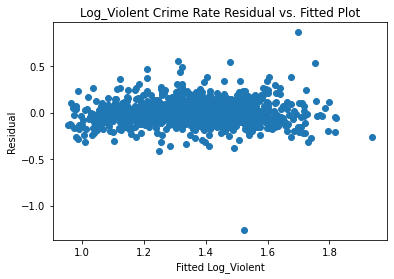

In [50]:
plt.scatter(OLS_out.fittedvalues, OLS_out.resid)
# adding title and labels
plt.xlabel('Fitted Log_Violent')
plt.ylabel('Residual')
plt.title('Log_Violent Crime Rate Residual vs. Fitted Plot')
plt.show()

(array([  1.,   0.,   0.,   0.,  35., 509., 394.,  38.,   5.,   1.]),
 array([-9.77096289, -8.1310255 , -6.49108812, -4.85115074, -3.21121335,
        -1.57127597,  0.06866141,  1.7085988 ,  3.34853618,  4.98847356,
         6.62841094]),
 <BarContainer object of 10 artists>)

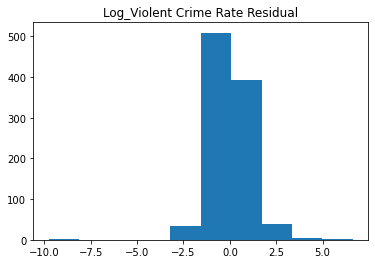

In [51]:
student_resid = sm.regression.linear_model.OLSResults.outlier_test(OLS_out)
plt.title('Log_Violent Crime Rate Residual') 
plt.hist(student_resid.student_resid)

Text(0.5, 1.0, 'Q-Q')

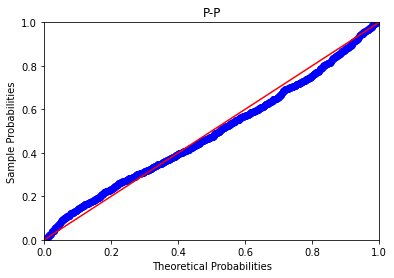

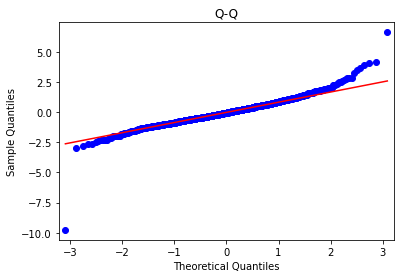

In [52]:
pp_qq_plot = sm.ProbPlot(student_resid.student_resid)
pp_qq_plot.ppplot(line = '45')
plt.title('P-P')

pp_qq_plot.qqplot(line = 'q')
plt.title('Q-Q')

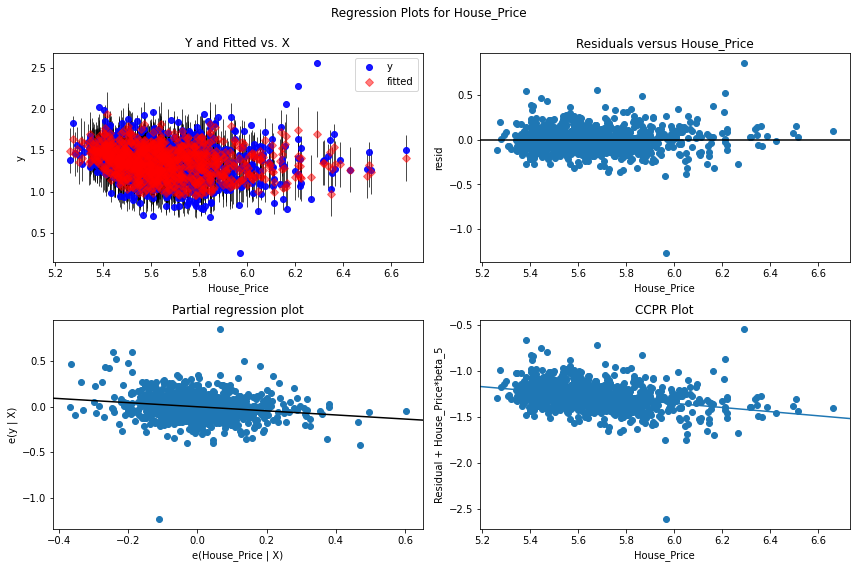

In [54]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(OLS_out, 'House_Price', fig=fig)